In [1]:
!apt install sox

Reading package lists... Done
Building dependency tree       
Reading state information... Done
sox is already the newest version (14.4.2-3ubuntu0.18.04.1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


### Baseline commands recognition (2-5 points)

We're now going to train a classifier to recognize voice. More specifically, we'll use the [Speech Commands Dataset] that contains around 30 different words with a few thousand voice records each.

In [2]:
import os
from IPython.display import display, Audio
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import librosa
import torch
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
datadir = "speech_commands"

!wget http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz -O speech_commands_v0.01.tar.gz
# alternative url: https://www.dropbox.com/s/j95n278g48bcbta/speech_commands_v0.01.tar.gz?dl=1
!mkdir {datadir} && tar -C {datadir} -xvzf speech_commands_v0.01.tar.gz 1> log

samples_by_target = {
    cls: [os.path.join(datadir, cls, name) for name in os.listdir("./speech_commands/{}".format(cls))]
    for cls in os.listdir(datadir)
    if os.path.isdir(os.path.join(datadir, cls))
}
print('Classes:', ', '.join(sorted(samples_by_target.keys())[1:]))

--2021-10-24 17:43:06--  http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 74.125.70.128, 2607:f8b0:4001:c02::80
Connecting to download.tensorflow.org (download.tensorflow.org)|74.125.70.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1489096277 (1.4G) [application/gzip]
Saving to: ‘speech_commands_v0.01.tar.gz’

speech_commands_v0. 100%[===================>]   1.39G   212MB/s    in 6.6s    

2021-10-24 17:43:12 (214 MB/s) - ‘speech_commands_v0.01.tar.gz’ saved [1489096277/1489096277]

Classes: bed, bird, cat, dog, down, eight, five, four, go, happy, house, left, marvin, nine, no, off, on, one, right, seven, sheila, six, stop, three, tree, two, up, wow, yes, zero


In [ ]:
!sox --info speech_commands/bed/00176480_nohash_0.wav


Input File     : 'speech_commands/bed/00176480_nohash_0.wav'
Channels       : 1
Sample Rate    : 16000
Precision      : 16-bit
Duration       : 00:00:01.00 = 16000 samples ~ 75 CDDA sectors
File Size      : 32.0k
Bit Rate       : 256k
Sample Encoding: 16-bit Signed Integer PCM



In [3]:
from sklearn.model_selection import train_test_split
from itertools import chain
from tqdm.notebook import tqdm
import joblib as jl
import pickle

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
classes = ("left", "right", "up", "down", "stop")

def preprocess_sample(filepath, max_length=150):
    amplitudes, sr = librosa.core.load(filepath)
    spectrogram = librosa.feature.melspectrogram(amplitudes, sr=sr)[:, :max_length]
    spectrogram = np.pad(spectrogram, [[0, 0], [0, max(0, max_length - spectrogram.shape[1])]], mode='constant')
    target = classes.index(filepath.split(os.sep)[-2])
    return np.float32(spectrogram), np.int64(target)

all_files = chain(*(samples_by_target[cls] for cls in classes))
spectrograms_and_targets = jl.Parallel(n_jobs=-1)(tqdm(list(map(jl.delayed(preprocess_sample), all_files))))
X, y = map(np.stack, zip(*spectrograms_and_targets))
X = X.transpose([0, 2, 1])  # to [batch, time, channels]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

100%|██████████| 11834/11834 [07:26<00:00, 26.49it/s]


In [ ]:
Audio('speech_commands/down/00176480_nohash_0.wav')

## Попробуем сетку на 1D свертках

In [ ]:
X_trainn = X_train.reshape(8875, 128, 150)
X_testt = X_test.reshape(2959, 128, 150)

In [ ]:
batch_size = 32

tensor_x = torch.Tensor(X_trainn)
tensor_y = torch.LongTensor(y_train)

train_dataset = TensorDataset(tensor_x, tensor_y)

tensor_x = torch.Tensor(X_testt) # transform to torch tensor
tensor_y = torch.LongTensor(y_test)

test_dataset = TensorDataset(tensor_x, tensor_y)


trainloader = DataLoader(train_dataset, batch_size=batch_size,
                         shuffle=True, num_workers=2, drop_last=True)
testloader = DataLoader(test_dataset, batch_size=batch_size,
                        shuffle=False, num_workers=2, drop_last=True)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Net_Conv1D(nn.Module):
    def __init__(self, n_input=1, n_output=5, stride=5, n_channel=32):
        super().__init__()
        # TODO: define your layers here
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        nn.init.xavier_normal_(self.conv1.weight) # проинициализируем веса (так лучше учится)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        nn.init.xavier_normal_(self.conv2.weight)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        nn.init.xavier_normal_(self.conv3.weight)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=1)
        nn.init.xavier_normal_(self.conv4.weight)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        # TODO: apply your layers here
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        x = x.reshape(32, 5)
        return F.softmax(x)

# net on 1D conv layers with 128 input channels
net_1D_conv = Net_Conv1D(n_input=128, n_output=5).to(device)

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net_1D_conv.parameters(), lr=0.01)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

In [ ]:
from tqdm.notebook import tqdm

losses_train = []

for epoch in tqdm(range(50)):  # loop over the dataset multiple times
    epoch_loss = 0.0
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs = inputs.to(device)
        labels = labels.to(device)
        # print(labels)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net_1D_conv(inputs)
        # print(outputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics

        running_loss += loss.item()
        epoch_loss += loss.item()
        if i % 200 == 199:    # print every 200 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0
    losses_train.append(epoch_loss)
print('Finished Training')

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[1,   200] loss: 1.587
[2,   200] loss: 1.518
[3,   200] loss: 1.496
[4,   200] loss: 1.468
[5,   200] loss: 1.453
[6,   200] loss: 1.434
[7,   200] loss: 1.418
[8,   200] loss: 1.401
[9,   200] loss: 1.383
[10,   200] loss: 1.380
[11,   200] loss: 1.363
[12,   200] loss: 1.351
[13,   200] loss: 1.331
[14,   200] loss: 1.326
[15,   200] loss: 1.323
[16,   200] loss: 1.315
[17,   200] loss: 1.304
[18,   200] loss: 1.294
[19,   200] loss: 1.298
[20,   200] loss: 1.290
[21,   200] loss: 1.282
[22,   200] loss: 1.281
[23,   200] loss: 1.270
[24,   200] loss: 1.255
[25,   200] loss: 1.265
[26,   200] loss: 1.251
[27,   200] loss: 1.243
[28,   200] loss: 1.241
[29,   200] loss: 1.243
[30,   200] loss: 1.238
[31,   200] loss: 1.229
[32,   200] loss: 1.223
[33,   200] loss: 1.231
[34,   200] loss: 1.227
[35,   200] loss: 1.221
[36,   200] loss: 1.225
[37,   200] loss: 1.226
[38,   200] loss: 1.220
[39,   200] loss: 1.210
[40,   200] loss: 1.206
[41,   200] loss: 1.199
[42,   200] loss: 1.207
[

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f13607d99e0>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f13607d99e0>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Traceback (most recent call last):
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    assert self._parent_pid == os.getpid(), 'can only test a child process'
    if w.is_alive():
AssertionError: can only test a child process
  File "/usr/lib/pytho

[50,   200] loss: 1.191
Finished Training


### Лосс падает нереально

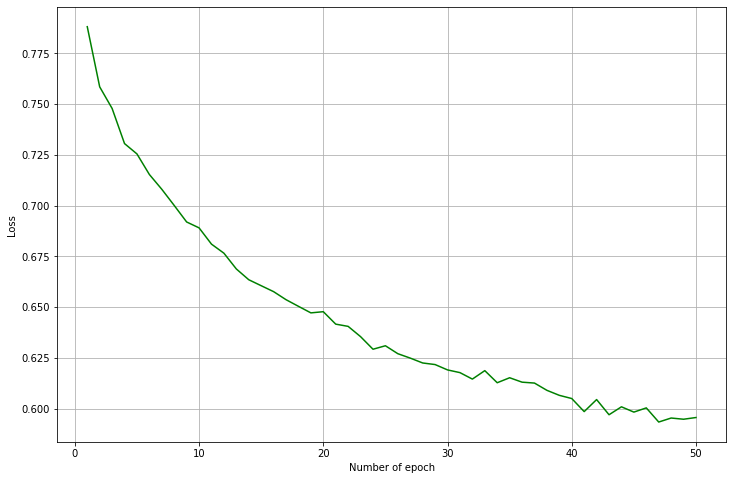

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
plt.xlabel('Number of epoch')
plt.ylabel('Loss')
plt.plot(range(1, 51), np.array(losses_train) / (X_train.shape[0] // 16), color='green')
plt.grid()

In [ ]:
correct_test = 0
total_test = 0

with torch.no_grad():

    for inputs, labels in testloader:
        
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = net_1D_conv(inputs)
        _, predicted = torch.max(outputs.data, 1)

      
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()
    # print(f'Correct = {correct}, total = {total}, percent = {correct / total}')
print(f'Accuracy of the network on the {X_test.shape[0]} test inputs = {round(100 * correct_test / total_test, 2)}%')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy of the network on the 2959 test inputs = 54.65%


### Если вдруг пропадут output-ы:
Accuracy of the network net_2D_conv on the 2959 test inputs = 54.65%

### Считаю, что норм качество (не 20%)

## Попробуем 2D свертки, посмотрим что из этого выйдет

In [ ]:
X_tr = X_train[:, None, :, :]
X_te = X_test[:, None, :, :]

In [ ]:
batch_size = 16

tensor_x = torch.Tensor(X_tr)
tensor_y = torch.LongTensor(y_train)

train_dataset = TensorDataset(tensor_x, tensor_y)

tensor_x = torch.Tensor(X_te) # transform to torch tensor
tensor_y = torch.LongTensor(y_test)

test_dataset = TensorDataset(tensor_x, tensor_y)


trainloader = DataLoader(train_dataset, batch_size=batch_size,
                         shuffle=True, num_workers=2, drop_last=True)
testloader = DataLoader(test_dataset, batch_size=batch_size,
                        shuffle=False, num_workers=2, drop_last=True)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Net_Conv2D(nn.Module):
    def __init__(self, n_input=1, n_output=5, stride=5, n_channel=32):
        super().__init__()
        # TODO: define your layers here
        self.conv1 = nn.Conv2d(n_input, n_channel, kernel_size=5)
        nn.init.xavier_normal_(self.conv1.weight) # проинициализируем веса (так лучше учится)
        self.bn1 = nn.BatchNorm2d(n_channel)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(n_channel, n_channel, kernel_size=5)
        nn.init.xavier_normal_(self.conv2.weight)
        self.bn2 = nn.BatchNorm2d(n_channel)
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(n_channel, 2 * n_channel, kernel_size=3)
        nn.init.xavier_normal_(self.conv3.weight)
        self.bn3 = nn.BatchNorm2d(2 * n_channel)
        self.conv4 = nn.Conv2d(2 * n_channel, 2 * n_channel, kernel_size=3)
        nn.init.xavier_normal_(self.conv4.weight)
        self.bn4 = nn.BatchNorm2d(2 * n_channel)
        self.pool4 = nn.MaxPool2d(2)
        self.conv5 = nn.Conv2d(2 * n_channel, 2 * n_channel, kernel_size=3)
        nn.init.xavier_normal_(self.conv5.weight)
        self.bn5 = nn.BatchNorm2d(2 * n_channel)
        self.pool5 = nn.MaxPool2d(4)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(384, 128)
        nn.init.xavier_normal_(self.fc1.weight)
        self.fc2 = nn.Linear(128, n_output)
        nn.init.xavier_normal_(self.fc2.weight)

    def forward(self, x):
        # TODO: apply your layers here
        x = F.relu(self.pool1(self.bn1(self.conv1(x))))
        x = F.relu(self.pool2(self.bn2(self.conv2(x))))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.pool4(self.bn4(self.conv4(x))))
        x = F.relu(self.pool5(self.bn5(self.conv5(x))))
        x = self.flatten(x)
        # print(x.shape)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x)

# net on 2D conv layers with 1 input channels
net_2D_conv = Net_Conv2D(n_input=1, n_output=5).to(device)

In [ ]:
import torch.optim as optim

criterion_2D = nn.CrossEntropyLoss()
optimizer_2D = optim.Adam(net_2D_conv.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer_2D, step_size=10, gamma=0.4)

In [ ]:
from tqdm.notebook import tqdm

losses_train = []

for epoch in tqdm(range(30)):  # loop over the dataset multiple times
    epoch_loss = 0.0
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs = inputs.to(device)
        labels = labels.to(device)
        # print(inputs.shape)
        # zero the parameter gradients
        optimizer_2D.zero_grad()

        # forward + backward + optimize
        outputs = net_2D_conv(inputs)
        # print(outputs)
        loss = criterion_2D(outputs, labels)
        loss.backward()
        optimizer_2D.step()

        # print statistics

        running_loss += loss.item()
        epoch_loss += loss.item()
        if i % 200 == 199:    # print every 200 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0
    losses_train.append(epoch_loss)
    scheduler.step()
print('Finished Training')

  0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[1,   200] loss: 1.635
[1,   400] loss: 1.582
[2,   200] loss: 1.577
[2,   400] loss: 1.517
[3,   200] loss: 1.461
[3,   400] loss: 1.410
[4,   200] loss: 1.366
[4,   400] loss: 1.317
[5,   200] loss: 1.247
[5,   400] loss: 1.229
[6,   200] loss: 1.217
[6,   400] loss: 1.179
[7,   200] loss: 1.219
[7,   400] loss: 1.166
[8,   200] loss: 1.128
[8,   400] loss: 1.139
[9,   200] loss: 1.130
[9,   400] loss: 1.109
[10,   200] loss: 1.111
[10,   400] loss: 1.110
[11,   200] loss: 1.071
[11,   400] loss: 1.072
[12,   200] loss: 1.061
[12,   400] loss: 1.060
[13,   200] loss: 1.047
[13,   400] loss: 1.031
[14,   200] loss: 1.031
[14,   400] loss: 1.062
[15,   200] loss: 1.032
[15,   400] loss: 1.057
[16,   200] loss: 1.040
[16,   400] loss: 1.053
[17,   200] loss: 1.036
[17,   400] loss: 1.060
[18,   200] loss: 1.037
[18,   400] loss: 1.026
[19,   200] loss: 1.034
[19,   400] loss: 1.041
[20,   200] loss: 1.022
[20,   400] loss: 1.035
[21,   200] loss: 1.022
[21,   400] loss: 1.023
[22,   200

### Лосс падает еще нереальнее

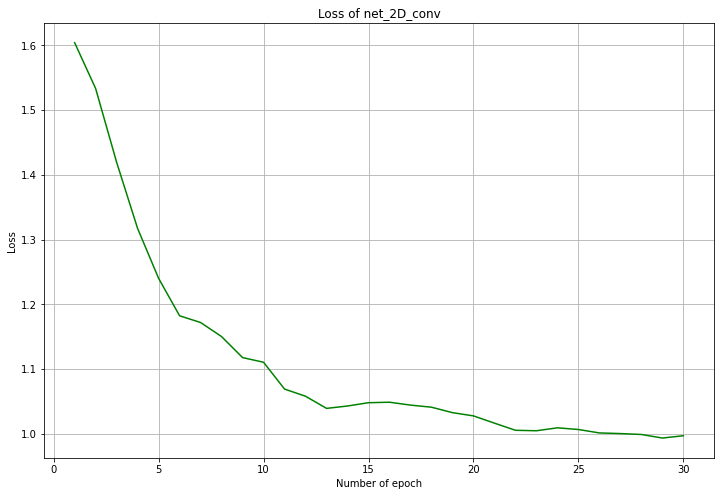

In [ ]:
plt.figure(figsize=(12, 8))
plt.xlabel('Number of epoch')
plt.ylabel('Loss')
plt.title('Loss of net_2D_conv')
plt.plot(range(1, 31), np.array(losses_train) / (X_train.shape[0] // batch_size), color='green')
plt.grid()

In [ ]:
correct_test = 0
total_test = 0

with torch.no_grad():

    for inputs, labels in testloader:
        
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = net_2D_conv(inputs)
        _, predicted = torch.max(outputs.data, 1)

        # print(f'Predicted = {predicted}\nLabels = {labels}\n')
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()
    # print(f'Correct = {correct}, total = {total}, percent = {correct / total}')
print(f'Accuracy of the network net_2D_conv on the {X_test.shape[0]} test inputs = {round(100 * correct_test / total_test, 2)}%')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy of the network net_2D_conv on the 2959 test inputs = 88.42%


### Если вдруг пропадут output-ы:
Accuracy of the network net_2D_conv on the 2959 test inputs = 88.42%

### Тут и говорить не о чем, далеко не 20%, качество - огонь! (менял параметры, лучше не получил)

## Попробуем VGG16

In [ ]:
X_tr = X_train[:, None, :, :]
X_te = X_test[:, None, :, :]

In [ ]:
batch_size = 128

tensor_x = torch.Tensor(X_tr)
tensor_y = torch.LongTensor(y_train)

train_dataset = TensorDataset(tensor_x, tensor_y)

tensor_x = torch.Tensor(X_te) # transform to torch tensor
tensor_y = torch.LongTensor(y_test)

test_dataset = TensorDataset(tensor_x, tensor_y)


trainloader = DataLoader(train_dataset, batch_size=batch_size,
                         shuffle=True, num_workers=2, drop_last=True)
testloader = DataLoader(test_dataset, batch_size=batch_size,
                        shuffle=False, num_workers=2, drop_last=True)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        self.conv1_1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1)
        nn.init.xavier_normal_(self.conv1_1.weight)
        self.conv1_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        nn.init.xavier_normal_(self.conv1_2.weight)

        self.conv2_1 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        nn.init.xavier_normal_(self.conv2_1.weight)
        self.conv2_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        nn.init.xavier_normal_(self.conv2_2.weight)

        self.conv3_1 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        nn.init.xavier_normal_(self.conv3_1.weight)
        self.conv3_2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        nn.init.xavier_normal_(self.conv3_2.weight)
        self.conv3_3 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        nn.init.xavier_normal_(self.conv3_3.weight)

        self.conv4_1 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        nn.init.xavier_normal_(self.conv4_1.weight)
        self.conv4_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        nn.init.xavier_normal_(self.conv4_2.weight)
        self.conv4_3 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        nn.init.xavier_normal_(self.conv4_3.weight)

        self.conv5_1 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        nn.init.xavier_normal_(self.conv5_1.weight)
        self.conv5_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        nn.init.xavier_normal_(self.conv5_2.weight)
        self.conv5_3 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        nn.init.xavier_normal_(self.conv5_3.weight)

        self.maxpool = nn.MaxPool2d(kernel_size=5, stride=2)

        self.fc1 = nn.Linear(512, 256)
        nn.init.xavier_normal_(self.fc1.weight)
        self.fc2 = nn.Linear(256, 128)
        nn.init.xavier_normal_(self.fc2.weight)
        self.fc3 = nn.Linear(128, 5)
        nn.init.xavier_normal_(self.fc3.weight)

    def forward(self, x):
        x = F.relu(self.conv1_1(x))
        x = F.relu(self.conv1_2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2_1(x))
        x = F.relu(self.conv2_2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv3_1(x))
        x = F.relu(self.conv3_2(x))
        x = F.relu(self.conv3_3(x))
        x = self.maxpool(x)
        x = F.relu(self.conv4_1(x))
        x = F.relu(self.conv4_2(x))
        x = F.relu(self.conv4_3(x))
        x = self.maxpool(x)
        x = F.relu(self.conv5_1(x))
        x = F.relu(self.conv5_2(x))
        x = F.relu(self.conv5_3(x))
        x = self.maxpool(x)
        x = x.reshape(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, 0.5)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, 0.5)
        x = self.fc3(x)
        return x

net_vgg = VGG16().to(device)

In [ ]:
import torch.optim as optim

criterion_vgg = nn.CrossEntropyLoss()
optimizer_vgg = optim.Adam(net_vgg.parameters(), lr=0.0001)
scheduler_vgg = optim.lr_scheduler.StepLR(optimizer_vgg, step_size=1, gamma=0.9)

In [ ]:
from tqdm.notebook import tqdm

losses_train_vgg = []

for epoch in tqdm(range(15)):  # loop over the dataset multiple times
    epoch_loss = 0.0
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs = inputs.to(device)
        labels = labels.to(device)
        # print(inputs.shape)
        # zero the parameter gradients
        optimizer_vgg.zero_grad()

        # forward + backward + optimize
        outputs = net_vgg(inputs)
        # print(outputs)
        loss = criterion_vgg(outputs, labels)
        loss.backward()
        optimizer_vgg.step()

        # print statistics

        running_loss += loss.item()
        epoch_loss += loss.item()
        if i % 10 == 9:    # print every 10 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 10))
            running_loss = 0.0
    losses_train_vgg.append(epoch_loss)
    scheduler_vgg.step()
print('Finished Training')

  0%|          | 0/15 [00:00<?, ?it/s]

[1,    10] loss: 1.684
[1,    20] loss: 1.612
[1,    30] loss: 1.610
[1,    40] loss: 1.610
[1,    50] loss: 1.603
[1,    60] loss: 1.608
[2,    10] loss: 1.613
[2,    20] loss: 1.609
[2,    30] loss: 1.605
[2,    40] loss: 1.608
[2,    50] loss: 1.604
[2,    60] loss: 1.607
[3,    10] loss: 1.602
[3,    20] loss: 1.601
[3,    30] loss: 1.598
[3,    40] loss: 1.587
[3,    50] loss: 1.589
[3,    60] loss: 1.587
[4,    10] loss: 1.568
[4,    20] loss: 1.597
[4,    30] loss: 1.584
[4,    40] loss: 1.550
[4,    50] loss: 1.552
[4,    60] loss: 1.533
[5,    10] loss: 1.520
[5,    20] loss: 1.476
[5,    30] loss: 1.486
[5,    40] loss: 1.447
[5,    50] loss: 1.388
[5,    60] loss: 1.356
[6,    10] loss: 1.291
[6,    20] loss: 1.237
[6,    30] loss: 1.255
[6,    40] loss: 1.230
[6,    50] loss: 1.153
[6,    60] loss: 1.119
[7,    10] loss: 1.031
[7,    20] loss: 0.937
[7,    30] loss: 0.925
[7,    40] loss: 0.915
[7,    50] loss: 0.894
[7,    60] loss: 0.951
[8,    10] loss: 0.787
[8,    20] 

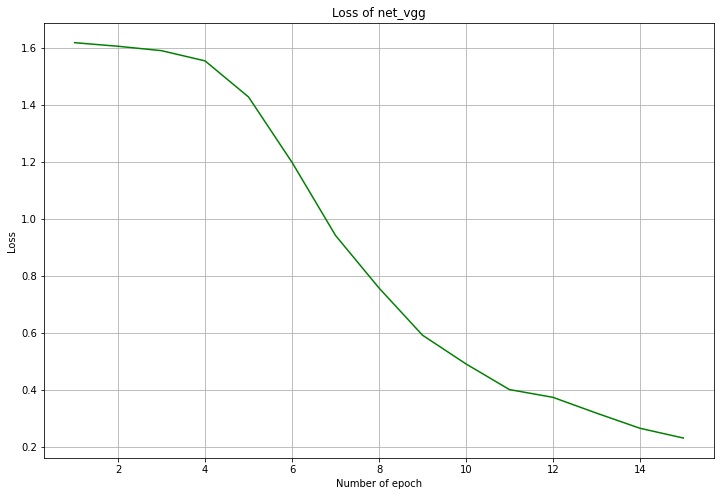

In [ ]:
plt.figure(figsize=(12, 8))
plt.xlabel('Number of epoch')
plt.ylabel('Loss')
plt.title('Loss of net_vgg')
plt.plot(range(1, 16), np.array(losses_train_vgg) / (X_train.shape[0] // batch_size), color='green')
plt.grid()

In [ ]:
correct_test = 0
total_test = 0

with torch.no_grad():

    for inputs, labels in testloader:
        
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = net_vgg(inputs)
        _, predicted = torch.max(outputs.data, 1)

      
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()
    # print(f'Correct = {correct}, total = {total}, percent = {correct / total}')
print(f'Accuracy of the VGG network on the {X_test.shape[0]} test inputs = {round(100 * correct_test / total_test, 2)}%')

Accuracy of the VGG network on the 2959 test inputs = 87.94%


Accuracy of the VGG network on the 2959 test inputs = 87.94%



### Ну норм, почти как моя (чуть похуже), можно было еще поучить, но лимит на GPU на колабе не бесконечный
### Ну и учится долговато, поэтому batch_size не получится особо уменьшить, короче, моя бесспорно лучше

## Попробуем ResNet

In [ ]:
X_tr = X_train[:, None, :, :]
X_te = X_test[:, None, :, :]

### Долго учится, но батч 128 не влезает в оперативу

In [ ]:
batch_size = 64

tensor_x = torch.Tensor(X_tr)
tensor_y = torch.LongTensor(y_train)

train_dataset = TensorDataset(tensor_x, tensor_y)

tensor_x = torch.Tensor(X_te) # transform to torch tensor
tensor_y = torch.LongTensor(y_test)

test_dataset = TensorDataset(tensor_x, tensor_y)


trainloader = DataLoader(train_dataset, batch_size=batch_size,
                         shuffle=True, num_workers=2, drop_last=True)
testloader = DataLoader(test_dataset, batch_size=batch_size,
                        shuffle=False, num_workers=2, drop_last=True)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

model = models.resnet50(pretrained=False)
model.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1, bias=False)
model = model.to(device)

In [ ]:
import torch.optim as optim

criterion_resnet = nn.CrossEntropyLoss()
optimizer_resnet = optim.Adam(model.parameters(), lr=0.0001)
scheduler_resnet = optim.lr_scheduler.StepLR(optimizer_resnet, step_size=1, gamma=0.9)

In [ ]:
from tqdm.notebook import tqdm

losses_train_resnet = []

for epoch in tqdm(range(5)):  # loop over the dataset multiple times
    epoch_loss = 0.0
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs = inputs.to(device)
        labels = labels.to(device)
        # print(inputs.shape)
        # zero the parameter gradients
        optimizer_resnet.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        # print(outputs)
        loss = criterion_resnet(outputs, labels)
        loss.backward()
        optimizer_resnet.step()

        # print statistics

        running_loss += loss.item()
        epoch_loss += loss.item()
        if i % 10 == 9:    # print every 10 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 10))
            running_loss = 0.0
    losses_train_resnet.append(epoch_loss)
    scheduler_resnet.step()
print('Finished Training')

  0%|          | 0/5 [00:00<?, ?it/s]

[1,    10] loss: 5.891
[1,    20] loss: 3.562
[1,    30] loss: 1.771
[1,    40] loss: 1.603
[1,    50] loss: 1.600
[1,    60] loss: 1.583
[1,    70] loss: 1.519
[1,    80] loss: 1.505
[1,    90] loss: 1.448
[1,   100] loss: 1.423
[1,   110] loss: 1.387
[1,   120] loss: 1.298
[1,   130] loss: 1.140
[2,    10] loss: 0.985
[2,    20] loss: 0.923
[2,    30] loss: 0.849
[2,    40] loss: 0.825
[2,    50] loss: 0.752
[2,    60] loss: 0.684
[2,    70] loss: 0.718
[2,    80] loss: 0.787
[2,    90] loss: 0.732
[2,   100] loss: 0.650
[2,   110] loss: 0.630
[2,   120] loss: 0.556
[2,   130] loss: 0.527
[3,    10] loss: 0.502
[3,    20] loss: 0.449
[3,    30] loss: 0.522
[3,    40] loss: 0.490
[3,    50] loss: 0.408
[3,    60] loss: 0.489
[3,    70] loss: 0.398
[3,    80] loss: 0.427
[3,    90] loss: 0.440
[3,   100] loss: 0.407
[3,   110] loss: 0.341
[3,   120] loss: 0.382
[3,   130] loss: 0.431
[4,    10] loss: 0.259
[4,    20] loss: 0.290
[4,    30] loss: 0.247
[4,    40] loss: 0.264
[4,    50] 

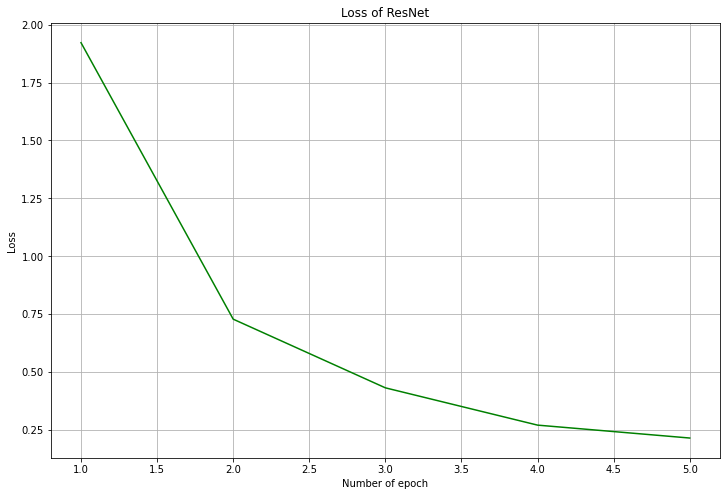

In [ ]:
plt.figure(figsize=(12, 8))
plt.xlabel('Number of epoch')
plt.ylabel('Loss')
plt.title('Loss of ResNet')
plt.plot(range(1, 6), np.array(losses_train_resnet) / (X_train.shape[0] // batch_size), color='green')
plt.grid()

In [ ]:
correct_test = 0
total_test = 0

with torch.no_grad():

    for inputs, labels in testloader:
        
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

      
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()
    # print(f'Correct = {correct}, total = {total}, percent = {correct / total}')
print(f'Accuracy of the ResNet50 network on the {X_test.shape[0]} test inputs = {round(100 * correct_test / total_test, 2)}%')

Accuracy of the ResNet50 network on the 2959 test inputs = 90.46%


Accuracy of the ResNet50 network on the 2959 test inputs = 90.46%

### Топчик!

Train a model: finally, lets' build and train a classifier neural network. You can use any library you like. If in doubt, consult the model & training tips below.

__Training tips:__ here's what you can try:
* __Layers:__ 1d or 2d convolutions, perhaps with some batch normalization in between;
* __Architecture:__ VGG-like, residual, highway, densely-connected, MatchboxNet, Dilated convs - you name it :)
* __Batch size matters:__ smaller batches usually train slower but better. Try to find the one that suits you best.
* __Data augmentation:__ add background noise, faster/slower, change pitch;
* __Average checkpoints:__ you can make model more stable with [this simple technique (arxiv)](https://arxiv.org/abs/1803.05407)
* __For full scale stage:__ make sure you're not losing too much data due to max_length in the pre-processing stage!

These are just recommendations. As long as your model works, you're not required to follow them.

## Full scale commands recognition (3+ points)

Your final task is to train a full-scale voice command spotter and apply it to a video:
1. Build the dataset with all 30+ classes (directions, digits, names, etc.)
  * __Optional:__ include a special "noise" class that contains random unrelated sounds
  * You can download youtube videos with [`youtube-dl`](https://ytdl-org.github.io/youtube-dl/index.html) library.
2. Train a model on this full dataset. Kudos for tuning its accuracy :)
3. Apply it to a audio/video of your choice to spot the occurences of each keyword
 * Here's one [video about primes](https://www.youtube.com/watch?v=EK32jo7i5LQ) that you can try. It should be full of numbers :)
 * There are multiple ways you can analyze the performance of your network, e.g. plot probabilities predicted for every time-step. Chances are you'll discover something useful about how to improve your model :)


Please briefly describe what you did in a short informal report.

### Соберем датасет со всеми классами

In [ ]:
tuple(sorted(samples_by_target.keys()))[1:]

('bed',
 'bird',
 'cat',
 'dog',
 'down',
 'eight',
 'five',
 'four',
 'go',
 'happy',
 'house',
 'left',
 'marvin',
 'nine',
 'no',
 'off',
 'on',
 'one',
 'right',
 'seven',
 'sheila',
 'six',
 'stop',
 'three',
 'tree',
 'two',
 'up',
 'wow',
 'yes',
 'zero')

### Не хватает оперативы, пришлось батчами датасет собирать:(
  (думаю, это заслуживает дополнительного балла)

### Преобразованные батчи:
('left', 'right', 'up', 'down', 'stop') \
('bed', 'bird', 'cat', 'dog', 'eight', 'five', 'four') \
('go', 'happy', 'house', 'marvin', 'nine', 'no', 'off', 'on') \
('one', 'seven', 'sheila', 'six', 'three', 'tree', 'two', 'wow', 'yes', 'zero')

In [ ]:
from sklearn.model_selection import train_test_split
from itertools import chain
from tqdm import tqdm
import joblib as jl

classes = ('one', 'seven', 'sheila', 'six', 'three', 'tree', 'two', 'wow', 'yes', 'zero')

def preprocess_sample(filepath, max_length=150):
    amplitudes, sr = librosa.core.load(filepath)
    spectrogram = librosa.feature.melspectrogram(amplitudes, sr=sr)[:, :max_length]
    spectrogram = np.pad(spectrogram, [[0, 0], [0, max(0, max_length - spectrogram.shape[1])]], mode='constant')
    target = classes.index(filepath.split(os.sep)[-2])
    return np.float32(spectrogram), np.int64(target)

all_files = chain(*(samples_by_target[cls] for cls in classes))
spectrograms_and_targets = jl.Parallel(n_jobs=-1)(tqdm(list(map(jl.delayed(preprocess_sample), all_files))))
X, y = map(np.stack, zip(*spectrograms_and_targets))
X = X.transpose([0, 2, 1])  # to [batch, time, channels]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

100%|██████████| 21810/21810 [13:33<00:00, 26.82it/s]


In [ ]:
%%time
with open('/content/drive/MyDrive/speech_technology/X_train_one_seven_sheila_six_three_tree_two_wow_yes_zero.pickle', 'wb') as f:
  pickle.dump(X_train, f)

with open('/content/drive/MyDrive/speech_technology/X_test_one_seven_sheila_six_three_tree_two_wow_yes_zero.pickle', 'wb') as f:
  pickle.dump(X_test, f)

with open('/content/drive/MyDrive/speech_technology/y_train_one_seven_sheila_six_three_tree_two_wow_yes_zero.pickle', 'wb') as f:
  pickle.dump(y_train, f)

with open('/content/drive/MyDrive/speech_technology/y_test_one_seven_sheila_six_three_tree_two_wow_yes_zero.pickle', 'wb') as f:
  pickle.dump(y_test, f)

CPU times: user 2.82 s, sys: 1.89 s, total: 4.71 s
Wall time: 12.4 s


In [ ]:
!ls /content/drive/MyDrive/speech_technology/

X_test_bed_bird_cat_dog_eight_five_four.pickle
X_test_go_happy_house_marvin_nine_no_off_on.pickle
X_test_left_right_up_down_stop.pickle
X_test_one_seven_sheila_six_three_tree_two_wow_yes_zero.pickle
X_train_bed_bird_cat_dog_eight_five_four.pickle
X_train_go_happy_house_marvin_nine_no_off_on.pickle
X_train_left_right_up_down_stop.pickle
X_train_one_seven_sheila_six_three_tree_two_wow_yes_zero.pickle
y_test_bed_bird_cat_dog_eight_five_four.pickle
y_test_go_happy_house_marvin_nine_no_off_on.pickle
y_test_left_right_up_down_stop.pickle
y_test_one_seven_sheila_six_three_tree_two_wow_yes_zero.pickle
y_train_bed_bird_cat_dog_eight_five_four.pickle
y_train_go_happy_house_marvin_nine_no_off_on.pickle
y_train_left_right_up_down_stop.pickle
y_train_one_seven_sheila_six_three_tree_two_wow_yes_zero.pickle


### Собираем батчи в единые массивы

In [ ]:
empty = True
for file in tqdm(['X_train_bed_bird_cat_dog_eight_five_four.pickle', 'X_train_go_happy_house_marvin_nine_no_off_on.pickle', 
             'X_train_left_right_up_down_stop.pickle', 'X_train_one_seven_sheila_six_three_tree_two_wow_yes_zero.pickle']):
  with open(f'/content/drive/MyDrive/speech_technology/{file}', 'rb') as f:
    if empty:
      X_train = pickle.load(f)
      empty = False
    else:
      X_train = np.concatenate((X_train, pickle.load(f)))

  0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
empty = True
for file in ['X_test_bed_bird_cat_dog_eight_five_four.pickle', 'X_test_go_happy_house_marvin_nine_no_off_on.pickle', 
             'X_test_left_right_up_down_stop.pickle', 'X_test_one_seven_sheila_six_three_tree_two_wow_yes_zero.pickle']:
  with open(f'/content/drive/MyDrive/speech_technology/{file}', 'rb') as f:
    if empty:
      X_test = pickle.load(f)
      empty = False
    else:
      X_test = np.concatenate((X_test, pickle.load(f)))

In [ ]:
empty = True
shift = 0
for file in ['y_train_bed_bird_cat_dog_eight_five_four.pickle', 'y_train_go_happy_house_marvin_nine_no_off_on.pickle', 
             'y_train_left_right_up_down_stop.pickle', 'y_train_one_seven_sheila_six_three_tree_two_wow_yes_zero.pickle']:
  with open(f'/content/drive/MyDrive/speech_technology/{file}', 'rb') as f:
    if empty:
      y_train = pickle.load(f)
      empty = False
    else:
      y_train_new = pickle.load(f)
      shift = y_train.max() + 1
      y_train = np.concatenate((y_train, y_train_new + shift))

In [ ]:
empty = True
shift = 0
for file in ['y_test_bed_bird_cat_dog_eight_five_four.pickle', 'y_test_go_happy_house_marvin_nine_no_off_on.pickle', 
             'y_test_left_right_up_down_stop.pickle', 'y_test_one_seven_sheila_six_three_tree_two_wow_yes_zero.pickle']:
  with open(f'/content/drive/MyDrive/speech_technology/{file}', 'rb') as f:
    if empty:
      y_test = pickle.load(f)
      empty = False
    else:
      y_test_new = pickle.load(f)
      shift = y_test.max() + 1
      y_test = np.concatenate((y_test, y_test_new + shift))

### Пишем все файлы на диск, чтобы миллион раз не ждать обработку

In [ ]:
%%time
with open('/content/drive/MyDrive/speech_technology/X_train.pickle', 'wb') as f:
  pickle.dump(X_train, f)

with open('/content/drive/MyDrive/speech_technology/X_test.pickle', 'wb') as f:
  pickle.dump(X_test, f)

CPU times: user 1.64 s, sys: 6.06 s, total: 7.7 s
Wall time: 1min 30s


In [ ]:
with open('/content/drive/MyDrive/speech_technology/y_train.pickle', 'wb') as f:
  pickle.dump(y_train, f)

with open('/content/drive/MyDrive/speech_technology/y_test.pickle', 'wb') as f:
  pickle.dump(y_test, f)

### Читаем данные с диска

In [6]:
print('reading X_train...')
with open('/content/drive/MyDrive/speech_technology/X_train.pickle', 'rb') as f:
  X_train = pickle.load(f)
print('reading X_test...')
with open('/content/drive/MyDrive/speech_technology/X_test.pickle', 'rb') as f:
  X_test = pickle.load(f)
print('reading y_train...')
with open('/content/drive/MyDrive/speech_technology/y_train.pickle', 'rb') as f:
  y_train = pickle.load(f)
print('reading y_test...')
with open('/content/drive/MyDrive/speech_technology/y_test.pickle', 'rb') as f:
  y_test = pickle.load(f)

reading X_train...
reading X_test...
reading y_train...
reading y_test...


In [7]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((48539, 150, 128), (16182, 150, 128), (48539,), (16182,))

In [8]:
y_train.max(), y_train.min(), y_test.max(), y_test.min()

(29, 0, 29, 0)

### Буду учить ResNet - добавил чекпоинты для модели, потому что колаб очень неприятно слетает в самый подходящий момент

In [9]:
X_train = X_train[:, None, :, :]
X_test = X_test[:, None, :, :]

In [10]:
batch_size = 64

tensor_x = torch.Tensor(X_train)
tensor_y = torch.LongTensor(y_train)

train_dataset = TensorDataset(tensor_x, tensor_y)

tensor_x = torch.Tensor(X_test) # transform to torch tensor
tensor_y = torch.LongTensor(y_test)

test_dataset = TensorDataset(tensor_x, tensor_y)


trainloader = DataLoader(train_dataset, batch_size=batch_size,
                         shuffle=True, num_workers=2, drop_last=True)
testloader = DataLoader(test_dataset, batch_size=batch_size,
                        shuffle=False, num_workers=2, drop_last=True)

In [11]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

In [ ]:
model = models.resnet50(pretrained=False)
model.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1, bias=False)
model = model.to(device)

In [ ]:
import torch.optim as optim

criterion_resnet = nn.CrossEntropyLoss()
optimizer_resnet = optim.Adam(model.parameters(), lr=0.0001)
scheduler_resnet = optim.lr_scheduler.StepLR(optimizer_resnet, step_size=1, gamma=0.9)

In [ ]:
from tqdm.notebook import tqdm

losses_train_resnet = []

for epoch in tqdm(range(2)):  # loop over the dataset multiple times
    epoch_loss = 0.0
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs = inputs.to(device)
        labels = labels.to(device)
        # print(inputs.shape)
        # zero the parameter gradients
        optimizer_resnet.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        # print(outputs)
        loss = criterion_resnet(outputs, labels)
        loss.backward()
        optimizer_resnet.step()

        # print statistics

        running_loss += loss.item()
        epoch_loss += loss.item()
        if i % 50 == 49:    # print every 50 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 10))
            running_loss = 0.0
            if i % 200 == 199: # model checkpoints
              torch.save(model, f'/content/drive/MyDrive/speech_technology/ResNet50_full_dataset_epoch_{epoch}_stage_{i}')
              print(f'Saved model ResNet50_full_dataset_epoch_{epoch}_stage_{i}')
    losses_train_resnet.append(epoch_loss)
    scheduler_resnet.step()
print('Finished Training')

  0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[1,    50] loss: 21.973
[1,   100] loss: 16.892
[1,   150] loss: 16.088
[1,   200] loss: 14.136
Saved model ResNet50_full_dataset_epoch_0_stage_199
[1,   250] loss: 12.016
[1,   300] loss: 10.419
[1,   350] loss: 8.925
[1,   400] loss: 7.628
Saved model ResNet50_full_dataset_epoch_0_stage_399
[1,   450] loss: 6.816
[1,   500] loss: 5.738
[1,   550] loss: 5.185
[1,   600] loss: 4.999
Saved model ResNet50_full_dataset_epoch_0_stage_599
[1,   650] loss: 4.319
[1,   700] loss: 4.071
[1,   750] loss: 3.788
[2,    50] loss: 3.209
[2,   100] loss: 3.318
[2,   150] loss: 3.015
[2,   200] loss: 2.857
Saved model ResNet50_full_dataset_epoch_1_stage_199
[2,   250] loss: 2.804
[2,   300] loss: 2.596
[2,   350] loss: 2.573
[2,   400] loss: 2.628
Saved model ResNet50_full_dataset_epoch_1_stage_399
[2,   450] loss: 2.312
[2,   500] loss: 2.238
[2,   550] loss: 2.356
[2,   600] loss: 2.177
Saved model ResNet50_full_dataset_epoch_1_stage_599
[2,   650] loss: 2.286
[2,   700] loss: 2.230
[2,   750] loss

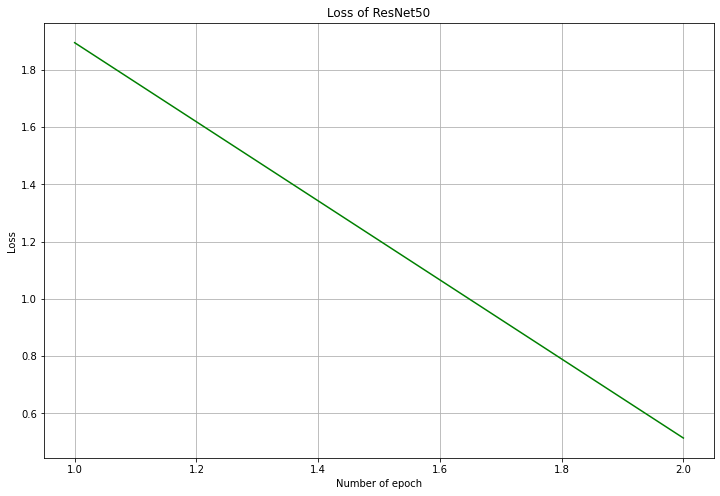

In [ ]:
plt.figure(figsize=(12, 8))
plt.xlabel('Number of epoch')
plt.ylabel('Loss')
plt.title('Loss of ResNet50')
plt.plot(range(1, 3), np.array(losses_train_resnet) / (X_train.shape[0] // batch_size), color='green')
plt.grid()

In [ ]:
torch.save(model, '/content/drive/MyDrive/speech_technology/ResNet50_full_dataset')

In [ ]:
correct_test = 0
total_test = 0

with torch.no_grad():

    for inputs, labels in tqdm(testloader):
        
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

      
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()
    # print(f'Correct = {correct}, total = {total}, percent = {correct / total}')
print(f'Accuracy of the ResNet50 network on the {X_test.shape[0]} test inputs = {round(100 * correct_test / total_test, 2)}%')

  0%|          | 0/252 [00:00<?, ?it/s]

Accuracy of the ResNet50 network on the 16182 test inputs = 75.08%


### Хочется еще эпоху

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

In [12]:
model = torch.load('/content/drive/MyDrive/speech_technology/ResNet50_full_dataset')

In [13]:
model = model.to(device)

In [16]:
import torch.optim as optim

criterion_resnet = nn.CrossEntropyLoss()
optimizer_resnet = optim.Adam(model.parameters(), lr=0.00001)
scheduler_resnet = optim.lr_scheduler.StepLR(optimizer_resnet, step_size=1, gamma=0.9)

In [17]:
from tqdm.notebook import tqdm

losses_train_resnet = []

for epoch in tqdm(range(3, 4)):
    epoch_loss = 0.0
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs = inputs.to(device)
        labels = labels.to(device)
        # print(inputs.shape)
        # zero the parameter gradients
        optimizer_resnet.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        # print(outputs)
        loss = criterion_resnet(outputs, labels)
        loss.backward()
        optimizer_resnet.step()

        # print statistics

        running_loss += loss.item()
        epoch_loss += loss.item()
        if i % 50 == 49:    # print every 50 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch, i + 1, running_loss / 10))
            running_loss = 0.0
            if i % 200 == 199: # model checkpoints
              torch.save(model, f'/content/drive/MyDrive/speech_technology/ResNet50_full_dataset_epoch_{epoch}_stage_{i}')
              print(f'Saved model ResNet50_full_dataset_epoch_{epoch}_stage_{i}')
    losses_train_resnet.append(epoch_loss)
    scheduler_resnet.step()
print('Finished Training')

  0%|          | 0/1 [00:00<?, ?it/s]

[3,    50] loss: 1.256
[3,   100] loss: 1.201
[3,   150] loss: 1.092
[3,   200] loss: 1.070
Saved model ResNet50_full_dataset_epoch_3_stage_199
[3,   250] loss: 1.033
[3,   300] loss: 1.041
[3,   350] loss: 1.066
[3,   400] loss: 1.138
Saved model ResNet50_full_dataset_epoch_3_stage_399
[3,   450] loss: 1.101
[3,   500] loss: 1.060
[3,   550] loss: 1.052
[3,   600] loss: 1.046
Saved model ResNet50_full_dataset_epoch_3_stage_599
[3,   650] loss: 1.000
[3,   700] loss: 0.983
[3,   750] loss: 0.979
Finished Training


In [18]:
torch.save(model, '/content/drive/MyDrive/speech_technology/ResNet50_full_dataset_latest')

In [19]:
correct_test = 0
total_test = 0

with torch.no_grad():

    for inputs, labels in tqdm(testloader):
        
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

      
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()
    # print(f'Correct = {correct}, total = {total}, percent = {correct / total}')
print(f'Accuracy of the ResNet50 network on the {X_test.shape[0]} test inputs = {round(100 * correct_test / total_test, 2)}%')

  0%|          | 0/252 [00:00<?, ?it/s]

Accuracy of the ResNet50 network on the 16182 test inputs = 82.51%


Accuracy of the ResNet50 network on the 16182 test inputs = 82.51%

## Попробуем считать видосик с ютуба

In [40]:
!sudo curl -L https://yt-dl.org/downloads/latest/youtube-dl -o /usr/local/bin/youtube-dl

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100     3  100     3    0     0      1      0  0:00:03  0:00:02  0:00:01     1
100     3  100     3    0     0      1      0  0:00:03  0:00:02  0:00:01     1
100   614  100   614    0     0    193      0  0:00:03  0:00:03 --:--:--   193
100 1797k  100 1797k    0     0   506k      0  0:00:03  0:00:03 --:--:-- 19.7M


In [41]:
!sudo chmod a+rx /usr/local/bin/youtube-dl

In [43]:
!youtube-dl --list-formats https://www.youtube.com/watch?v=EK32jo7i5LQ

[youtube] EK32jo7i5LQ: Downloading webpage
[info] Available formats for EK32jo7i5LQ:
format code  extension  resolution note
249          webm       audio only tiny   55k , webm_dash container, opus @ 55k (48000Hz), 8.86MiB
250          webm       audio only tiny   73k , webm_dash container, opus @ 73k (48000Hz), 11.81MiB
140          m4a        audio only tiny  129k , m4a_dash container, mp4a.40.2@129k (44100Hz), 20.83MiB
251          webm       audio only tiny  141k , webm_dash container, opus @141k (48000Hz), 22.81MiB
160          mp4        256x144    144p   25k , mp4_dash container, avc1.4d400c@  25k, 30fps, video only, 4.07MiB
394          mp4        256x144    144p   44k , mp4_dash container, av01.0.00M.08@  44k, 30fps, video only, 7.13MiB
278          webm       256x144    144p   46k , webm_dash container, vp9@  46k, 30fps, video only, 7.48MiB
133          mp4        426x240    240p   55k , mp4_dash container, avc1.4d4015@  55k, 30fps, video only, 8.89MiB
242          webm     

In [44]:
!youtube-dl -o '/content/drive/MyDrive/speech_technology/youtube_video_1.wav' -x --audio-format wav https://www.youtube.com/watch?v=EK32jo7i5LQ

[youtube] EK32jo7i5LQ: Downloading webpage
[download] Destination: /content/drive/MyDrive/speech_technology/youtube_video_1.wav
[download] 100% of 22.81MiB in 06:19
[ffmpeg] Post-process file /content/drive/MyDrive/speech_technology/youtube_video_1.wav exists, skipping


### Создадим словарик для соответствия индексов и таргетов (цифра <-> слово)

In [30]:
target_words_ordered = 'bed_bird_cat_dog_eight_five_four'.split('_') + 'go_happy_house_marvin_nine_no_off_on'.split('_') + \
                        'left_right_up_down_stop'.split('_') + 'one_seven_sheila_six_three_tree_two_wow_yes_zero'.split('_')

target_to_word = {
    ind: word for ind, word in enumerate(target_words_ordered)
}

In [109]:
!sox --info /content/drive/MyDrive/speech_technology/prime_numbers_mono.wav


Input File     : '/content/drive/MyDrive/speech_technology/prime_numbers_mono.wav'
Channels       : 1
Sample Rate    : 16000
Precision      : 16-bit
Duration       : 00:22:29.52 = 21592247 samples ~ 101214 CDDA sectors
File Size      : 43.2M
Bit Rate       : 256k
Sample Encoding: 16-bit Signed Integer PCM



In [122]:
%%time
amplitudes, sr = librosa.core.load('/content/drive/MyDrive/speech_technology/prime_numbers_mono.wav')

CPU times: user 38.5 s, sys: 230 ms, total: 38.7 s
Wall time: 39.5 s


In [123]:
spectrogram = librosa.feature.melspectrogram(amplitudes, sr=sr)

In [125]:
spectrogram.shape

(128, 58119)

### Нарезал спектрограмму окошком длины 150

In [129]:
samples = []
for i in tqdm(range(0, spectrogram.shape[1]-150, 10)):
  samples.append(spectrogram[:, i:i + 150])

  0%|          | 0/5797 [00:00<?, ?it/s]

In [130]:
samples = np.float32(samples)

In [131]:
samples.shape

(5797, 128, 150)

In [132]:
samples = samples.transpose([0, 2, 1])

In [133]:
samples = samples[:, None, :, :]
samples.shape

(5797, 1, 150, 128)

In [134]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

In [135]:
model = torch.load('/content/drive/MyDrive/speech_technology/ResNet50_full_dataset_latest').to(device)

In [136]:
batch_size = 64

tensor_video = torch.Tensor(samples)

video_dataset = TensorDataset(tensor_video)

videoloader = DataLoader(video_dataset, batch_size=batch_size,
                         shuffle=False, num_workers=2, drop_last=True)

In [137]:
global_time = 0
with torch.no_grad():
    model.eval()
    for inputs in tqdm(videoloader):
      
        inputs = inputs[0].to(device)
        
        outputs = F.softmax(model(inputs)[:, :30])
        _, predicted = torch.max(outputs.data, 1)
        
        for i, pred in enumerate(predicted):
          if outputs[i, pred].item() > 0.9:
            print(f'Video TimeCode: {global_time} milliseconds \t Predicted word is "{target_to_word[pred.item()]}"')
          global_time += 5

  0%|          | 0/90 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


Video TimeCode: 480 milliseconds 	 Predicted word is "three"
Video TimeCode: 485 milliseconds 	 Predicted word is "three"
Video TimeCode: 490 milliseconds 	 Predicted word is "three"
Video TimeCode: 500 milliseconds 	 Predicted word is "three"
Video TimeCode: 585 milliseconds 	 Predicted word is "zero"
Video TimeCode: 605 milliseconds 	 Predicted word is "zero"
Video TimeCode: 615 milliseconds 	 Predicted word is "zero"
Video TimeCode: 705 milliseconds 	 Predicted word is "zero"
Video TimeCode: 1070 milliseconds 	 Predicted word is "three"
Video TimeCode: 1075 milliseconds 	 Predicted word is "three"
Video TimeCode: 1080 milliseconds 	 Predicted word is "three"
Video TimeCode: 1085 milliseconds 	 Predicted word is "three"
Video TimeCode: 1090 milliseconds 	 Predicted word is "three"
Video TimeCode: 1100 milliseconds 	 Predicted word is "three"
Video TimeCode: 1105 milliseconds 	 Predicted word is "three"
Video TimeCode: 1110 milliseconds 	 Predicted word is "three"
Video TimeCode: 1115

### Еще надо было, наверное, добавить в обучающую выборку пустой звук/шум, чтобы, если он не распознает слово, то выдает шум (пустой класс)

### Чё-то я запутался, кажется, не так подготовил спектрограмму для нарезания, или нарезаю не так, или идея по подготовке данных плохая, или еще где-то накосячил, всякое может быть, но у меня больше нет вариантов (точнее нет времени):(